In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import glob
import warnings
from IPython.display import display

warnings.filterwarnings('ignore')
mpl.rcParams['savefig.dpi'] = 128
mpl.rcParams['figure.dpi'] = 128
# Plot size to 14" x 7"
mpl.rc('figure', figsize = (14, 7))
# Font size to 14
mpl.rc('font', size = 14)
# Do not display top and right frame lines
mpl.rc('axes.spines', top = False, right = False)
# Remove grid lines
mpl.rc('axes', grid = False)
# Set backgound color to white
mpl.rc('axes', facecolor = 'white')


# read whole year data
allFiles = glob.glob("data/*.csv")
df = pd.DataFrame()
list_ = []
for file_ in allFiles:
    df = pd.read_csv(file_,index_col=None, header=0)
    list_.append(df)
df = pd.concat(list_)

In [2]:
selected_features = ['Marketing Code','Suburb', 'State','Post Code','Classification','Enquired',
                     'Loan Amount','loan_reason','property_use']
target = 'Enquiry Status';
whole_set = selected_features + [target]

df = df[whole_set]
df = df.replace('On Hold','Rejected')
# convert loan amount to number type, and change string to NaN
df['Loan Amount'] = pd.to_numeric(df['Loan Amount'],errors='coerce')
df = df.dropna(axis=0, how='any')
df = df[~df[target].isin(['In Progress','Just Received'])]

In [3]:
df['Enquired'] = pd.DatetimeIndex(df['Enquired'])
df['Loan Amount'] = df['Loan Amount'].astype(int)
df['Post Code'] = df['Post Code'].astype(int)

In [4]:
print("Shape of data frame: {}".format(df.shape))
print("Keys of enquiries_dataset: \n{}".format(df.keys()))
print("data ytpes of enquiries_dataset: \n{}".format(df.dtypes))

Shape of data frame: (33807, 10)
Keys of enquiries_dataset: 
Index(['Marketing Code', 'Suburb', 'State', 'Post Code', 'Classification',
       'Enquired', 'Loan Amount', 'loan_reason', 'property_use',
       'Enquiry Status'],
      dtype='object')
data ytpes of enquiries_dataset: 
Marketing Code            object
Suburb                    object
State                     object
Post Code                  int64
Classification            object
Enquired          datetime64[ns]
Loan Amount                int64
loan_reason               object
property_use              object
Enquiry Status            object
dtype: object


In [5]:
from datetime import datetime
from dateutil.parser import parse

# filter years
start_date = '2017-01-01' 
end_date = '2017-12-31'
mask = (df['Enquired'] > start_date) & (df['Enquired'] <= end_date)
df = df.loc[mask].reset_index(drop=True)

# remove Year feature since it is not important (show below random forest)
# data_set['Year'] = data_set['Enquired'].dt.year
df['Month'] = df['Enquired'].dt.month
df['Day'] = df['Enquired'].dt.day
df['Hour'] = df['Enquired'].dt.hour
df['Weekday'] = df['Enquired'].dt.weekday_name

df = df.loc[:,df.columns != 'Enquiried']

In [6]:
# encoded_columns = df.loc[:, df.columns != 'Loan Amount'].columns

In [7]:
print("List of data types: \n{}".format(df.dtypes))

encoded_columns = list(df.select_dtypes(include=['category','object']))

print("selected encoded_columns: \n{}".format(encoded_columns))
# encoded_columns = ['Marketing Code', 'Suburb','State','Classification','loan_reason','property_use','Enquiry Status','Weekday']

List of data types: 
Marketing Code            object
Suburb                    object
State                     object
Post Code                  int64
Classification            object
Enquired          datetime64[ns]
Loan Amount                int64
loan_reason               object
property_use              object
Enquiry Status            object
Month                      int64
Day                        int64
Hour                       int64
Weekday                   object
dtype: object
selected encoded_columns: 
['Marketing Code', 'Suburb', 'State', 'Classification', 'loan_reason', 'property_use', 'Enquiry Status', 'Weekday']


In [8]:
from sklearn.preprocessing import LabelEncoder

class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col].astype(str))
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

In [9]:
mce = MultiColumnLabelEncoder(columns = encoded_columns);
df = mce.fit_transform(df)
# mce.transform(df)
# display(df)

X = df[df.keys()]
X = X.drop(['Enquiry Status'],1)
X = X.drop(['Enquired'],1)
y = df[target]

In [10]:
from sklearn.model_selection import train_test_split

# split data and labels into a training and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y,
                     test_size=0.4,
                     random_state=0,
                     stratify=y)

/Users/mluo/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/mluo/anaconda3/lib/python3.6/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


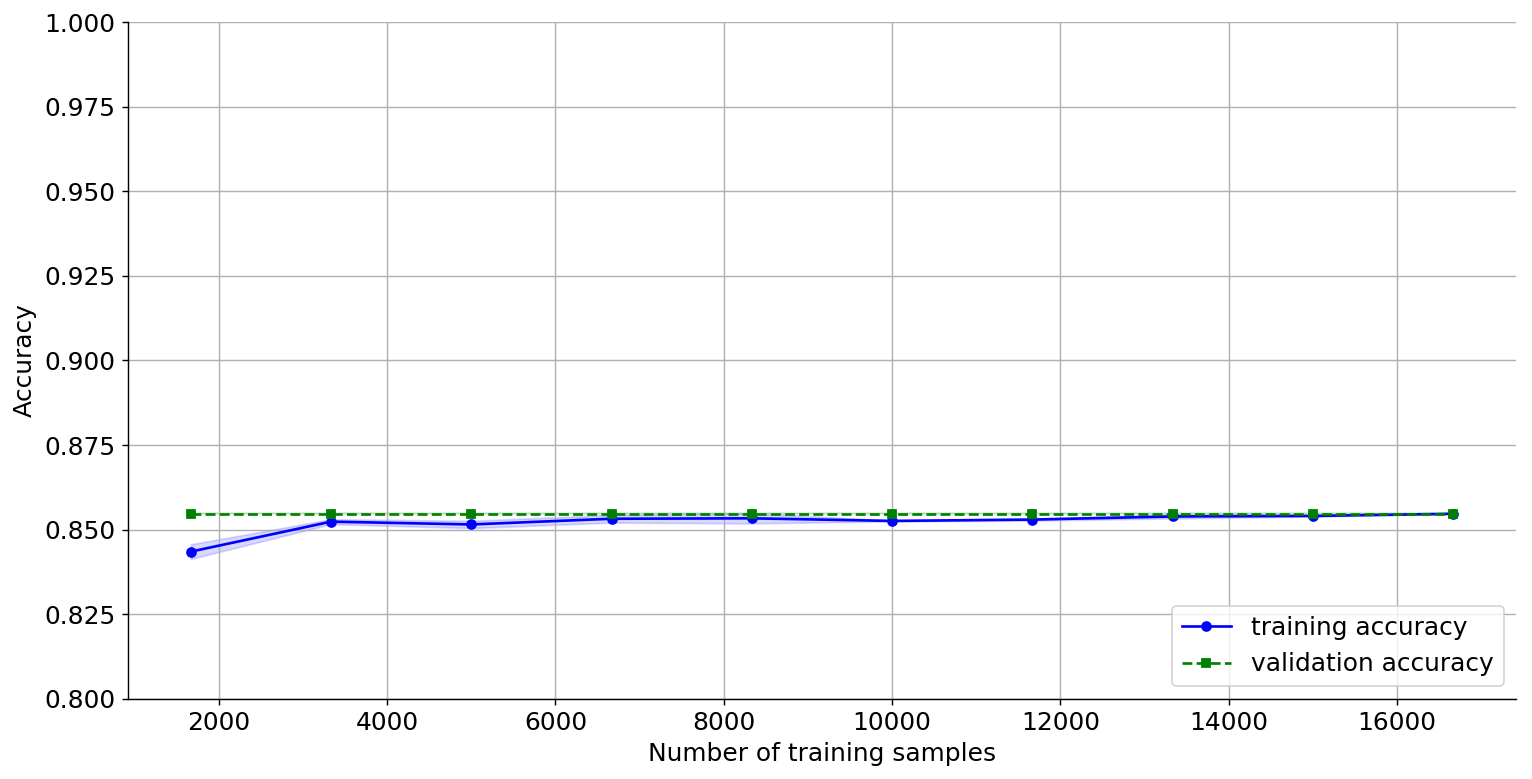

Test Accuracy: 0.855


In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.learning_curve import learning_curve

pipe_lr = make_pipeline(StandardScaler(),PCA(n_components=2),LogisticRegression(random_state=1))

train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_lr,
                                                        X=X_train,y=y_train,train_sizes=np.linspace(0.1, 1.0, 10),
                                                        cv=10,n_jobs=1)
train_mean = np.mean(train_scores,axis=1)
train_std = np.std(train_scores, axis=1)      
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)


plt.plot(train_sizes, train_mean,color='blue', marker='o',markersize=5,label='training accuracy')
plt.fill_between(train_sizes,train_mean + train_std,train_mean - train_std,alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean,color='green', linestyle='--',marker='s', markersize=5,label='validation accuracy')
plt.fill_between(train_sizes,test_mean + test_std,test_mean - test_std,alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')               
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])
plt.show()

pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
print('Test Accuracy: %.3f' % pipe_lr.score(X_test, y_test))

In [25]:
pipe_lr

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('logisticregression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=1, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

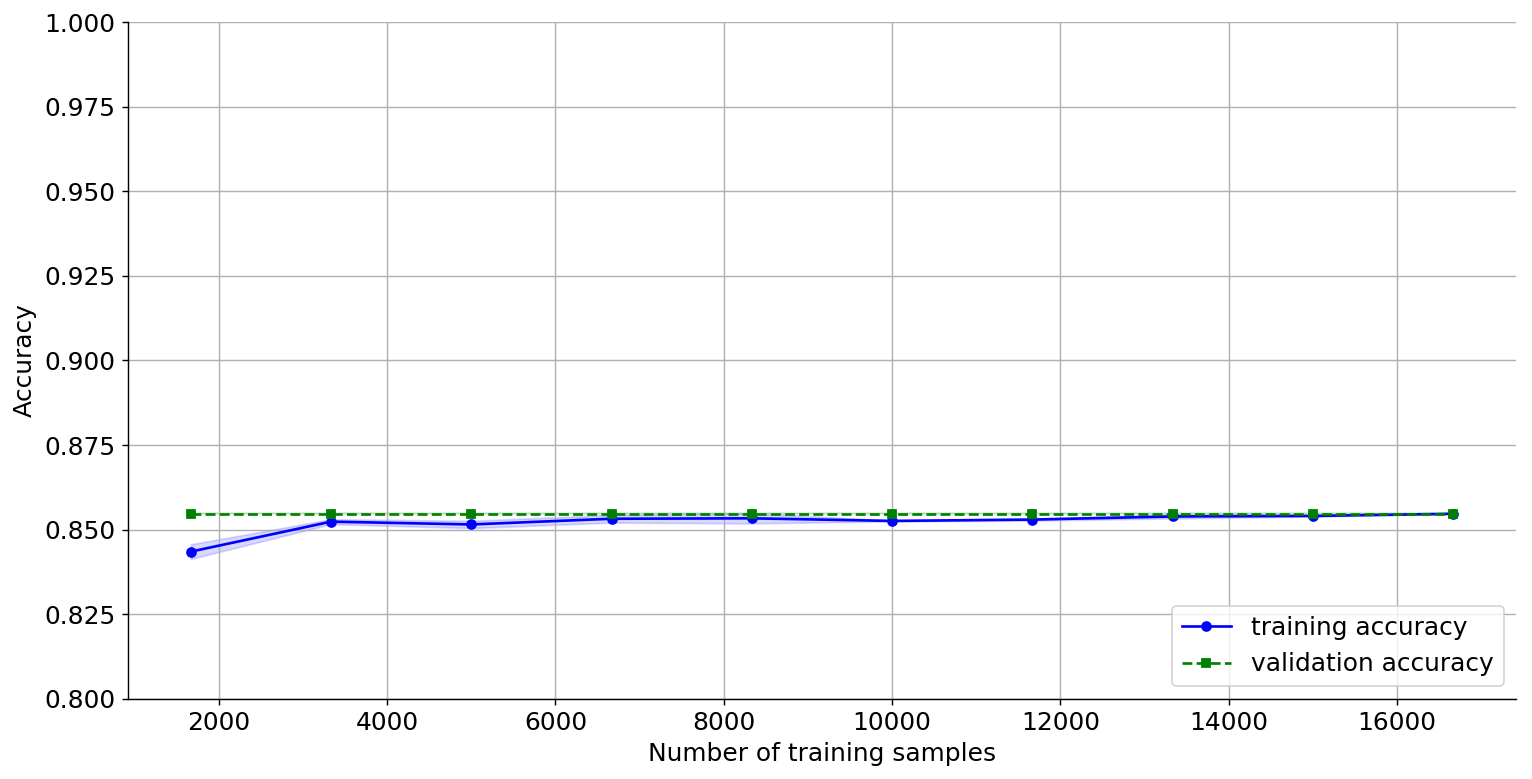

Test Accuracy: 0.855


In [12]:
from sklearn import svm

pipe_svm = make_pipeline(StandardScaler(),PCA(n_components=2),svm.SVC(C=0.1))

train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_svm,
                                                        X=X_train,y=y_train,train_sizes=np.linspace(0.1, 1.0, 10),
                                                        cv=10,n_jobs=1)
train_mean = np.mean(train_scores,axis=1)
train_std = np.std(train_scores, axis=1)      
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)


plt.plot(train_sizes, train_mean,color='blue', marker='o',markersize=5,label='training accuracy')
plt.fill_between(train_sizes,train_mean + train_std,train_mean - train_std,alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean,color='green', linestyle='--',marker='s', markersize=5,label='validation accuracy')
plt.fill_between(train_sizes,test_mean + test_std,test_mean - test_std,alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')               
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])
plt.show()

pipe_svm.fit(X_train, y_train)
y_svm_pred = pipe_svm.predict(X_test)
print('Test Accuracy: %.3f' % pipe_svm.score(X_test, y_test))

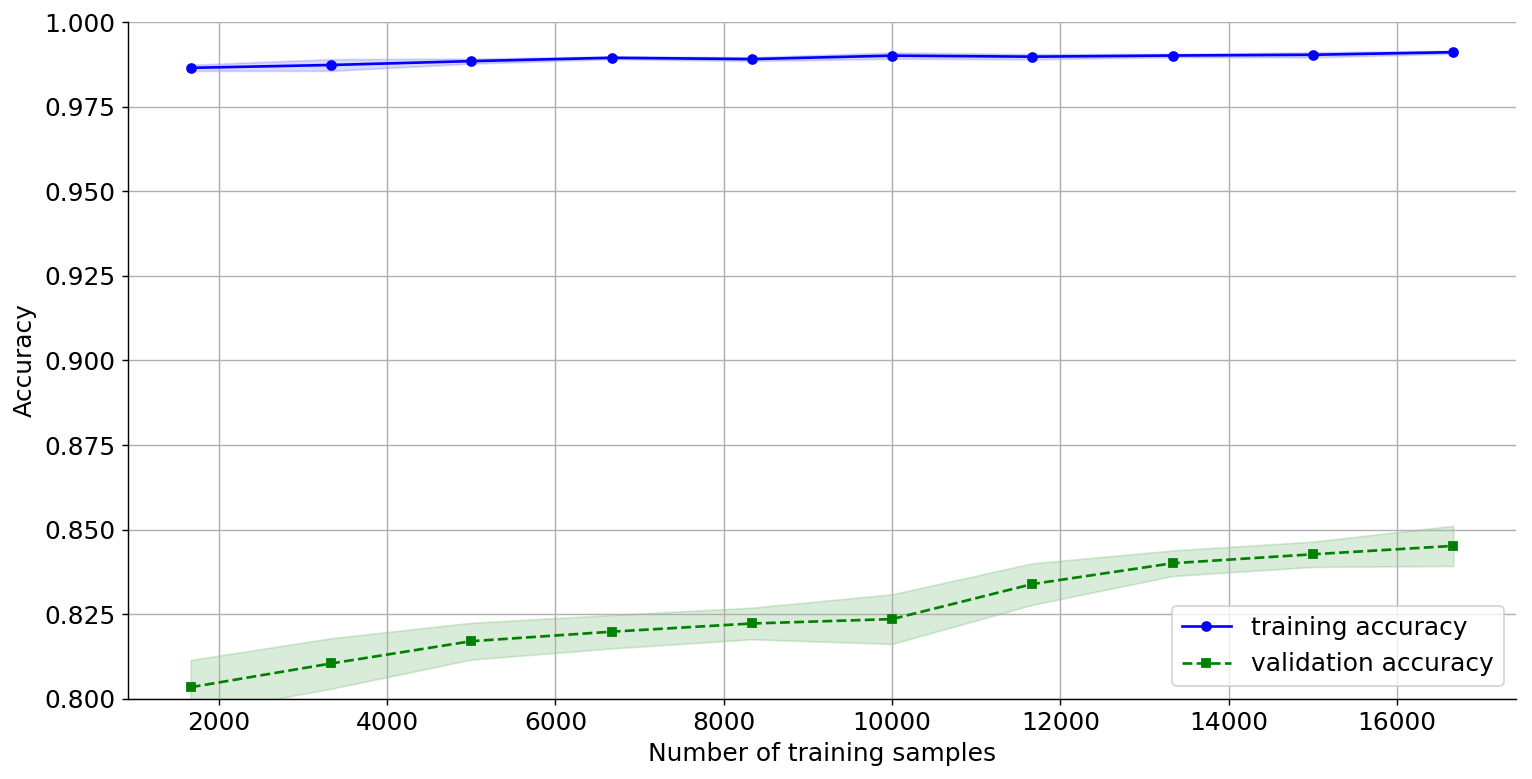

Test Accuracy: 0.847


In [13]:
from sklearn.ensemble import RandomForestClassifier

pipe_rn = make_pipeline(StandardScaler(),PCA(n_components=2),RandomForestClassifier(random_state=1))

train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_rn,
                                                        X=X_train,y=y_train,train_sizes=np.linspace(0.1, 1.0, 10),
                                                        cv=10,n_jobs=1)
train_mean = np.mean(train_scores,axis=1)
train_std = np.std(train_scores, axis=1)      
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)


plt.plot(train_sizes, train_mean,color='blue', marker='o',markersize=5,label='training accuracy')
plt.fill_between(train_sizes,train_mean + train_std,train_mean - train_std,alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean,color='green', linestyle='--',marker='s', markersize=5,label='validation accuracy')
plt.fill_between(train_sizes,test_mean + test_std,test_mean - test_std,alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')               
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])
plt.show()

pipe_rn.fit(X_train, y_train)
y_rn_pred = pipe_rn.predict(X_test)
print('Test Accuracy: %.3f' % pipe_rn.score(X_test, y_test))

In [14]:
from sklearn import cross_validation
from sklearn.metrics import classification_report

scores = cross_validation.cross_val_score(pipe_lr, X, y, cv=5)
print("LogisticRegression cross_validation: {:.2f}".format(np.mean(scores, axis=0)))
# print("LogisticRegression accuracy_score : {:.2f}".format(accuracy_score(y_test, y_pred)))
# print("LogisticRegression f1 score: {:.2f}".format(f1_score(y_test, y_pred,average='weighted')))
# print("LogisticRegression precision score: {:.2f}".format(precision_score(y_test, y_pred, average='weighted')))
print()
scores = cross_validation.cross_val_score(pipe_svm, X, y, cv=5)
print("SVC cross_validation: {:.2f}".format(np.mean(scores, axis=0)))

print()
scores = cross_validation.cross_val_score(pipe_rn, X, y, cv=5)
print("RandomForest cross_validation: {:.2f}".format(np.mean(scores, axis=0)))

print()
print("LogisticRegression")
print(classification_report(y_test, y_pred))

print("SVM")
print(classification_report(y_test, y_svm_pred))

print("RandomForest")
print(classification_report(y_test, y_rn_pred))

LogisticRegression cross_validation: 0.85

SVC cross_validation: 0.85

RandomForest cross_validation: 0.84

LogisticRegression
             precision    recall  f1-score   support

          0       0.00      0.00      0.00      1795
          1       0.85      1.00      0.92     10555

avg / total       0.73      0.85      0.79     12350

SVM
             precision    recall  f1-score   support

          0       0.00      0.00      0.00      1795
          1       0.85      1.00      0.92     10555

avg / total       0.73      0.85      0.79     12350

RandomForest
             precision    recall  f1-score   support

          0       0.46      0.29      0.36      1795
          1       0.89      0.94      0.91     10555

avg / total       0.82      0.85      0.83     12350



In [15]:
from sklearn.ensemble import RandomForestClassifier

from sklearn import metrics

# rescale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

rfc = RandomForestClassifier(n_estimators=500,random_state=1)
rfc.fit(X_train_scaled, y_train)
pred_forest = rfc.predict(X_test)

print("Test score: {:.2f}".format(rfc.score(X_test_scaled, y_test)))


Test score: 0.91


 1) Loan Amount                    0.131974
 2) Suburb                         0.130333
 3) Post Code                      0.122501
 4) Marketing Code                 0.113174
 5) loan_reason                    0.097811
 6) Day                            0.088130
 7) Hour                           0.080886
 8) Month                          0.059670
 9) Classification                 0.058387
10) Weekday                        0.052993
11) property_use                   0.035806
12) State                          0.028334


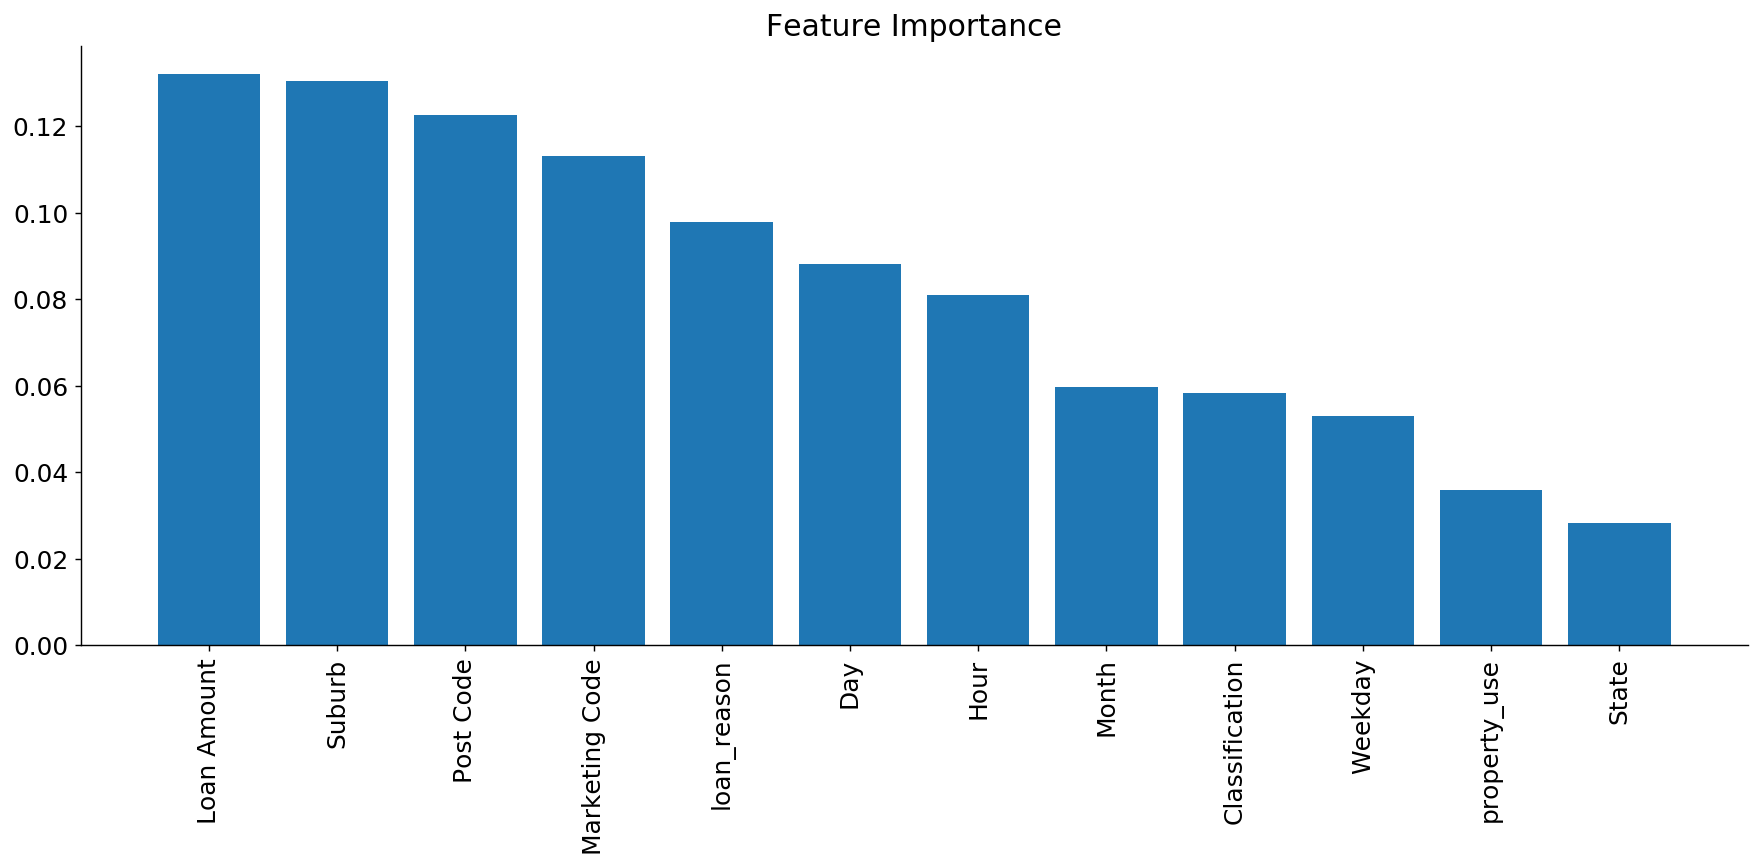

In [16]:
feat_labels = X.columns[0:]
importances = rfc.feature_importances_

# reverse the list
indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,feat_labels[indices[f]],importances[indices[f]]))
    
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]),importances[indices],align='center')
plt.xticks(range(X_train.shape[1]),feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

In [17]:
# input_x = df.iloc[:]
# input_x_test = df.iloc[:,idxs_selected]

# input_x_test = MultiColumnLabelEncoder(columns = input_x_test.keys()).fit_transform(input_x_test)
# input_x_test = scaler.fit_transform(input_x_test)

# result = rfc.predict(input_x_test)
# result = le.inverse_transform(result)
# proba = rfc.predict_proba(input_x_test)   
# proba = [np.max(p) for p in proba]

In [18]:
# input_x = input_x.assign(predict=result.tolist())
# input_x = input_x.assign(possibility=proba)
# input_x.to_csv('example_pipeline.csv')

In [19]:
# import pickle
# import os

# dest = os.path.join('movieclassifier', 'pkl_objects')
# if not os.path.exists(dest):
#     os.makedirs(dest)

# pickle.dump(stop,open(os.path.join(dest, 'stopwords.pkl'),'wb'),protocol=4)
# pickle.dump(clf,
            
from sklearn.externals import joblib
joblib.dump(pipe_lr, 'app/models/lrpipeline.pkl')

['app/models/lrpipeline.pkl']

In [20]:
model_columns = list(X.columns)
joblib.dump(model_columns, 'app/models/model_columns.pkl')

['app/models/model_columns.pkl']

In [21]:
clf = joblib.load('app/models/lrpipeline.pkl')
model_columns = joblib.load('app/models/model_columns.pkl')

In [22]:
data = "[\n  {\n    \"Marketing Code\": \"A9301\",\n    \"Classification\": \"Folio\",\n    \"Enquired\": \"27/10/14 18:53\",\n    \"Loan Amount\": 485000,\n    \"Suburb\": \"BYRON BAY\",\n    \"State\": \"NSW\",\n    \"Post Code\": 2481,\n    \"loan_reason\": \"First HomeBuyer\",\n    \"property_use\": \"Residence\"\n  },\n  {\n    \"Marketing Code\": \"P00019\",\n    \"Classification\": \"Domain Campaigns\",\n    \"Enquired\": \"15/5/15 10:26\",\n    \"Loan Amount\": 500000,\n    \"Suburb\": \"Sydney\",\n    \"State\": \"NSW\",\n    \"Post Code\": 2000,\n    \"loan_reason\": \"Refinance\",\n    \"property_use\": \"Residence\"\n  },\n  {\n    \"Marketing Code\": \"P00019\",\n    \"Classification\": \"Domain Campaigns\",\n    \"Enquired\": \"19/6/15 8:25\",\n    \"Loan Amount\": 500000,\n    \"Suburb\": \"Homebush West\",\n    \"State\": \"NSW\",\n    \"Post Code\": 2140,\n    \"loan_reason\": \"First HomeBuyer\",\n    \"property_use\": \"Residence\"\n  }\n]"

In [26]:
test = pd.read_json(data, orient='records')
# query = pd.get_dummies(test)

In [27]:
# print(test.dtypes)
# mce.transform(test)
# display(test)

In [ ]:
y = clf.predict(test)